In [169]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(2)

# MODEL CONSTANTS
n_realizations = 5

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 2

# TESTING
lams = [1/2, 1/10, 1/500, 1/10000]
sigma = 1
p = 5/7

In [170]:
# Load data file
dset = pd.read_csv("data/azdiabetes.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

y = dset["diabetes one-hot"].values
X = dset[["npreg", "glu", "bp", "skin", "bmi", "ped", "age"]].values

X = standardize(X)


<h2> Defining the Model </h2>

In [171]:
def model(alphas, lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter, Dx1
       array X: input data, NxD
       array y: output data, Nx1
    '''
    D = X.shape[1]
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D]))
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1-U))
    T = numpyro.deterministic("T", jnp.log(alphas) - jnp.log(1-alphas))
    z_lam = numpyro.deterministic("z_lam", ((lam**2+lam+1)/(lam+1)) * T + L)

    gammas = numpyro.deterministic("gammas", sigmoid(z_lam/lam))
    kappas = numpyro.deterministic("kappas", 1-gammas)
    y_mean = jnp.dot(X, gammas) #Nx1
    y = numpyro.sample("y", dist.Bernoulli(logits=y_mean), obs=y) 

In [172]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [173]:
def concrete(X, y, lam):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mses: size (D,)
       arr kappas: length len(A_values) * D
       arr mean_gammas: size (D,)
       arr betas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    alphas = jnp.zeros(X.shape[1])
    alphas += p 
    mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, y=y)
    samples = mcmc.get_samples()
    mean_gammas =  samples["gammas"]
    kappas = samples['kappas']
   #  plt.figure(figsize=(12, 6))
   #  print(mean_gammas.flatten())
   #  print(kappas)
   #  plt.subplot(1, 2, 1)
   #  sns.histplot(mean_gammas.flatten(), kde=True)
   #  plt.title('Distribution of Mean Gammas')

   #  plt.subplot(1, 2, 2)
   #  sns.histplot(kappas, kde=True)
   #  plt.title('Distribution of Kappas')

   #  plt.tight_layout()
   #  plt.show()
        
    return kappas, mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [174]:
all_mses = dict()
mean_mses = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for _ in range(n_realizations):
    for lam in lams:
        kappas, gammas, all_samples, mcmc = concrete(X, y, lam=lam)
        if lam not in all_kappas:
            all_kappas[lam] = []
        if lam not in mean_gammas:
            mean_gammas[lam] = []
        all_kappas[lam].append(kappas)
        mean_gammas[lam].append(gammas)
        all_mcmc_runs.append(mcmc)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_23716/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)


sample: 100%|██████████| 1500/1500 [00:00<00:00, 5079.21it/s, 15 steps of size 2.76e-01. acc. prob=0.92]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_23716/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 2655.39it/s, 47 steps of size 8.05e-02. acc. prob=0.96]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_23716/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [175]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.22      0.06      0.22      0.13      0.31   1373.10      1.00
      U[1]      0.74      0.15      0.74      0.52      0.99    952.48      1.00
      U[2]      0.05      0.04      0.05      0.00      0.11   1056.69      1.00
      U[3]      0.08      0.05      0.07      0.00      0.15    741.05      1.00
      U[4]      0.24      0.05      0.24      0.15      0.32   1059.63      1.00
      U[5]      0.24      0.05      0.24      0.16      0.32   1504.92      1.00
      U[6]      0.13      0.06      0.13      0.02      0.22    934.83      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.28      0.02      0.28      0.26      0.31    184.05      1.03
      U[1]      0.68      0.19      0.68      0.39      0.97    652.92      1.00
      U[2]      0.12      0.07      0.12      0.01      0.22    530.29      1.00


<h1> Results </h1>

0.5 [0.39765078 0.96925884 0.03993136 0.07912187 0.44434518 0.46221206
 0.17456281]
0.1 [0.46155083 0.9970874  0.00992331 0.02060184 0.48051256 0.45343366
 0.07446302]
0.002 [6.7702144e-01 9.9997091e-01 2.5609035e-05 1.0433178e-04 6.0496932e-01
 4.9961469e-01 2.4119457e-02]
0.0001 [9.6631730e-01 1.0000000e+00 6.1217176e-10 2.2726903e-08 9.8500001e-01
 5.2970243e-01 6.6423013e-08]


(-0.05, 1.05)

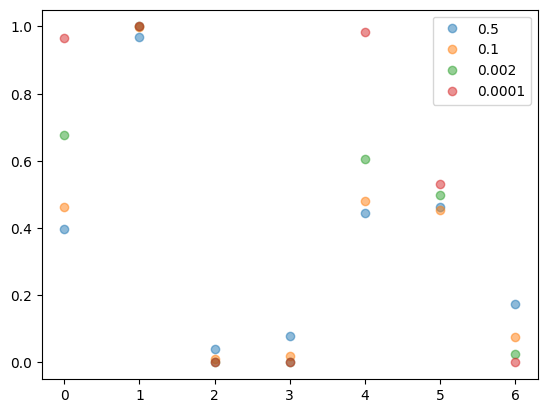

In [176]:
# for gamma in mean_gammas:
#     plt.plot(mean_gammas.keys(), mean_gammas.values(), '.', label=gamma, alpha=0.5)
# plt.legend()
# plt.title("Gamma values for different lambdas")
# plt.ylabel("Gamma")
# plt.xlabel("Entry #")

for lam in lams: 
    # for x in mean_gammas[lam]:
    #     plt.plot(x, '.', label=lam)
    #     # print(lam, mean_gammas[lam])
    plt.plot(np.array(mean_gammas[lam]).mean(0).mean(0), 'o', label=lam, alpha=0.5)
    print(lam, np.array(mean_gammas[lam]).mean(0).mean(0))

plt.legend()
plt.ylim(-0.05, 1.05)

(0.0, 1.0)

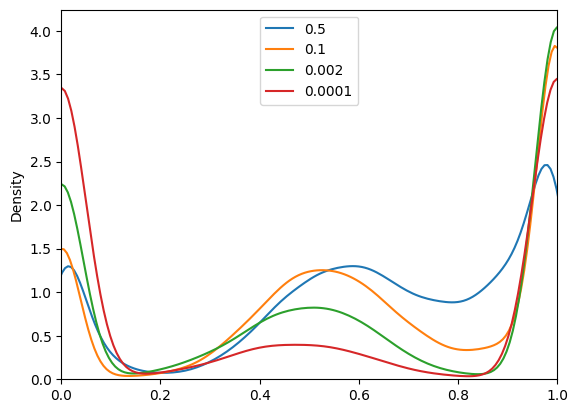

In [177]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()
plt.xlim(0, 1)

In [178]:
# samples_1 = mcmc.get_samples()
# predictive = Predictive(model, samples_1)
# predictions = predictive(random.PRNGKey(1),
#                          alphas = jnp.ones(X.shape[1]),
#                          lam=10000, 
#                          X=X,
#                          y=y)['y']
# mean_pred = predictions.mean(0)

# plt.plot(mean_pred, '.')
# plt.plot(y, '.')

# print(sum((mean_pred - y)**2))